# Variational Autoencoder
* paper: [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

## Implementation Details
* **Training Data**: `FGVC-Aircraft`
* **Goal**: Generate Random New Image of Aircraft
* **Encoder Layers**: *in progress*
* **Decoder Layers**: *in progress*

## Notes
* currently images still very noisy and not very good
    - will do more research and return to try to improve

In [ ]:
import torch
import torch.nn as nn

# Network

In [ ]:
from typing import List

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int=5, 
                 stride: int=2, padding: int=2):
        super().__init__()
        self.use_batchnorm = True
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                              padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(.2)

    def forward(self, X):
        out = self.conv(X)
        if self.use_batchnorm:
            out = self.bn(out)
        out = self.act(out)
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int=5,
                 stride: int=2, padding: int=2, out_padding: int=1):
        super().__init__()
        self.use_batchnorm = True
        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                        stride, padding, out_padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(.2)

    def forward(self, X):
        out = self.convT(X)
        if self.use_batchnorm:
            out = self.bn(out)
        out = self.act(out)
        return out

class Decoder(nn.Module):
    def __init__(self, channel_sizes: List[int], img_size: int=64, 
                 z_dim: int=512):
        super().__init__()
        num_samples = len(channel_sizes)-1
        self.in_dim = img_size//(2**num_samples)
        self.in_depth = channel_sizes[0]
        flat_size = self.in_depth * self.in_dim * self.in_dim
        up_layers = []
        for i in range(num_samples):
            up_layers.append(UpsampleBlock(channel_sizes[i],
                                               channel_sizes[i+1]))
        # Tanh on output layer
        up_layers[-1].act = nn.Tanh()
        self.upsample = nn.Sequential(*up_layers)
        self.fc = nn.Sequential(
            nn.Linear(z_dim, flat_size),
            nn.LeakyReLU(0.2),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1, self.in_depth, self.in_dim, self.in_dim)
        out= self.upsample(out)
        return out

class Encoder(nn.Module):
    def __init__(self, channel_sizes: List[int], img_size: int=64, 
                 z_dim: int=512):
        super().__init__()
        num_samples = len(channel_sizes)-1
        self.out_dim = img_size//(2**num_samples)
        self.out_depth = channel_sizes[-1]
        flat_size = self.out_depth * self.out_dim * self.out_dim
        down_layers = []
        for i in range(num_samples):
            down_layers.append(DownsampleBlock(channel_sizes[i],
                                               channel_sizes[i+1]))
        self.downsample = nn.Sequential(*down_layers)
        self.mean = nn.Linear(flat_size, z_dim)
        # TODO: need to experiment with this more
        # seems to sort of help with image noise by limiting variance
        self.logvar = nn.Sequential(
            nn.Linear(flat_size, z_dim),
            nn.Tanh()
        )
    
    def forward(self, X):
        out = self.downsample(X)
        out = torch.flatten(out, 1, 3)
        mean = self.mean(out)
        logvar = self.logvar(out)
        return mean, logvar

class VAE(nn.Module):
    def __init__(self, channel_sizes: List[int], img_size: int=64,
                 z_dim: int=512, device: str='cuda'):
        super().__init__()
        self.device = device
        self.enc = Encoder(channel_sizes, img_size, z_dim)
        self.dec = Decoder(channel_sizes[::-1], img_size)

    def sample(self, mean, logvar):
        var = torch.exp(logvar/2)
        return mean + var * torch.randn_like(logvar).to(self.device)

    def forward(self, X):
        mean, logvar = self.enc(X)
        sample = self.sample(mean, logvar)
        out = self.dec(sample)
        return out, mean, logvar

    def train_model(self):
        ...

# Getting Dataset

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
size = (64, 64)
train = datasets.FGVCAircraft(
    root = 'data',
    split = 'trainval',
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize(size)])
)

test = datasets.FGVCAircraft(
    root = 'data',
    split = 'test',
    download = True,
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize(size)])
)

  0%|          | 0/2753340328 [00:00<?, ?it/s]

Extracting data/fgvc-aircraft-2013b.tar.gz to data


In [ ]:
from torch.utils.data import DataLoader, Subset

def create_dataloaders(train_data: torch.Tensor, test_data: torch.Tensor, bs: int = 64):
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=True)
    return train_loader, test_loader

subset = True
train_loader = None
test_loader = None

# TODO: train using all of training images
# wanna wait until i feel a bit better about core model results
if subset:
    # train and test on small subset of data for now.
    train_ = Subset(train, range(750))
    train_loader, test_loader = create_dataloaders(train_, test, bs=64)

else:
    train_loader, test_loader = create_dataloaders(train, test, bs=64)

len(train_loader) * 64

768

# Train

In [ ]:
def kl_loss(mean: torch.Tensor, log_var: torch.Tensor):
    # paper uses sum, but wasn't really capturing variance of imgs
    # some things online suggested balacing issue between kl loss and other loss
    
    # using mean seemed to give "better" results. 

    # TODO: investigate the issue mentioned above more
    return -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

In [ ]:
def get_sample(mean: torch.Tensor, log_var: torch.Tensor):
    e = torch.randn_like(mean)
    var = torch.exp(log_var/2)
    return mean + var*e

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = 'cuda'

kl_losses = []
mse_losses = []
channel_sizes = [3, 32, 64, 64]
vae = VAE(channel_sizes).to(device)

In [ ]:
def train_model(model: nn.Module, train_loader: DataLoader, bs: int = 64, epochs: int = 10, device: str = 'cpu'):
    model.train()
    # TODO: Read Adam paper
    opt = optim.Adam(vae.parameters(), betas=(0.2, 0.999), lr=0.0003)
    for i in tqdm(range(epochs)):
        for batch, (X, _) in enumerate(train_loader):
            # train
            opt.zero_grad()

            X = X.to(device)
            out, mean, log_var = model(X)

            # TODO: investigate why vanishing loss
            # TODO: read b-vae paper
            # scale = i / 50
            kl = kl_loss(mean, log_var)
            # scaling the mean error seems to improve results a lot
            mse = 100*nn.MSELoss()(out, X)
            # mse = nn.MSELoss()(out, X)
            loss = kl + mse
            loss.backward()
  
            kl_losses.append(kl)
            mse_losses.append(mse)

            opt.step()

In [ ]:
train_model(vae, train_loader, epochs=50, device=device)

100%|██████████| 50/50 [14:38<00:00, 17.56s/it]


In [ ]:
torch.save(vae.state_dict(), './model.pth')

In [ ]:
!du -h -d 0 ./model.pth

52M	./model.pth


## Model Losses

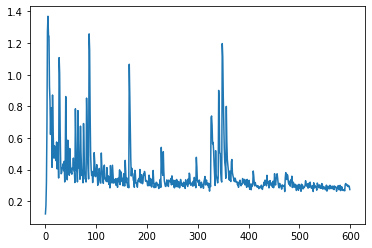

In [ ]:
import matplotlib.pyplot as plt
losses = list(map(lambda x: x.cpu().detach().numpy(), kl_losses))
plt.plot(losses)

# Test

## Model Outputs

695


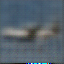

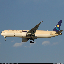

In [222]:
from PIL import Image
from random import randint

def to_image(inp, channels=3, size=(64,64), resize=True):
    ts = [transforms.ToPILImage(), transforms.Resize((256, 256))]
    
    t = transforms.ToPILImage() if not resize else transforms.Compose(ts)
    return t(inp.view(channels, size[0], size[1]))


'''
NOTE TO SELF:

* Make sure are using trained model for testing so you don't waste 5 hrs of your
  life again wondering why model is spitting out random noise and realize you're
  an idiot
'''

# data info
data = test
img_num = randint(0, len(data))
reference = data[img_num][0]
channels = reference.shape[0]
size = (reference.shape[1],reference.shape[2])

print(img_num)
# 769

# decoded image
vae.eval()
out, mu, log_sigma = vae(reference.view(1, channels, size[0], size[1]).to('cuda'))
img = to_image(out, size=size, resize=False)
display(img)

# true image
img = to_image(reference, size=size, resize=False)
display(img)

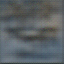

In [234]:
# z = get_sample(mu, log_sigma)
z = torch.randn_like(mu)
dec = vae.dec
out = dec(z)
img = to_image(out, resize=False)
img

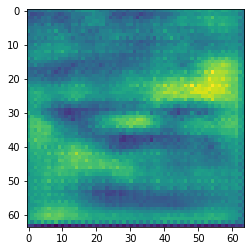

In [235]:
import matplotlib.pyplot as plt
plt.imshow(out[0][0].cpu().detach().numpy())